In [2]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
import numpy as np
from PIL import Image
# import polars as pd
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import random
import timeit
from tqdm import tqdm
from vit.model import ViT
from vit.fourier_vit import SpectreViT
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

In [3]:
RANDOM_SEED = 42
BATCH_SIZE = 256
EPOCHS = 300
# LEARNING_RATE = 1e-4
LEARNING_RATE = 1e-3
NUM_CLASSES = 100
PATCH_SIZE = 4
IMG_SIZE = 32
IN_CHANNELS = 3
NUM_HEADS = 12
DROPOUT = 0.001
# HIDDEN_DIM = 768
HIDDEN_DIM = 3072
# HIDDEN_DIM = 8
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 12
EMBED_DIM = (PATCH_SIZE**2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49
USE_SPECTRE=True
SPECTRE_THRESHOLD=1.0
USE_SPECTRE_VIT=False
EXPERIMENT_NAME="spectre_vit_cifar100"

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = 'cuda' if torch.cuda.is_available() else 'cpu'
writer = SummaryWriter(f'runs/{EXPERIMENT_NAME}')



In [4]:
# Test ViT
# model = ViT(IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
if USE_SPECTRE_VIT:
    model = SpectreViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
                num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
                num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
                use_spectre=USE_SPECTRE, spectre_threshold=SPECTRE_THRESHOLD).to(device)
else:
    model = ViT(img_size=IMG_SIZE, patch_size=PATCH_SIZE, in_channels=IN_CHANNELS, 
                num_classes=NUM_CLASSES, embed_dim=EMBED_DIM, num_encoders=NUM_ENCODERS, 
                num_heads=NUM_HEADS, hidden_dim=HIDDEN_DIM, dropout=DROPOUT, activation=ACTIVATION,
                use_spectre=USE_SPECTRE, spectre_threshold=SPECTRE_THRESHOLD).to(device)
# Print model params number
print(sum(p.numel() for p in model.parameters() if p.requires_grad))
# writer.add_graph(model, torch.randn(BATCH_SIZE, IN_CHANNELS, IMG_SIZE, IMG_SIZE).to(device))

3692716


/home/biblbrox/Phd/experiments/SpectralViT/vit/model.py:252: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39522225..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04358065..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21940142..1.4776516].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4478504..1.5126765].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.23527938..1.2073027].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4487329..1.377744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.088

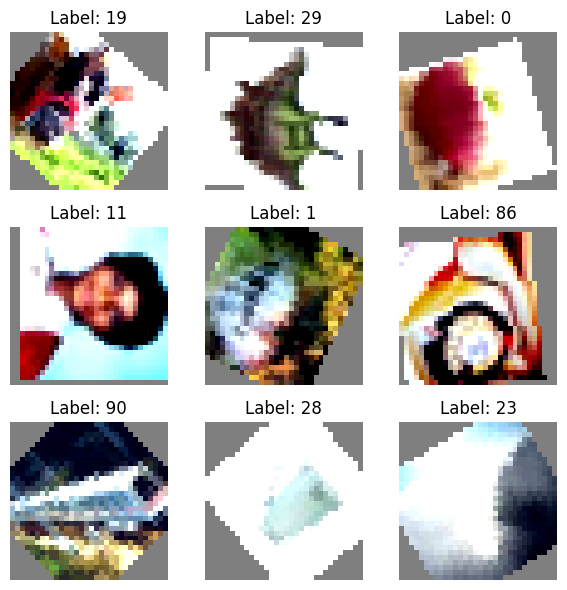

In [5]:
# Load CIFAR100 dataset
import torchvision

dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.5071, 0.4867, 0.4408),
        std=(0.2675, 0.2565, 0.2761)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(90)
]))

# Display sample images
fig, axes = plt.subplots(3, 3, figsize=(6,6))
for i, ax in enumerate(axes.flat):
    img, label = dataset[i]
    img =   img.permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # Unnormalize
    ax.imshow(img)
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# Split dataset into train, validation, and test sets
train_val_indices, test_indices = train_test_split(list(range(len(dataset))), test_size=0.2, random_state=RANDOM_SEED)
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.1, random_state=RANDOM_SEED)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [ ]:
use_amp = False

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
optimizer = optim.AdamW(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)
#scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
start = timeit.default_timer()
for epoch in range(EPOCHS):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0

    for idx, img_label in enumerate(train_dataloader):
        img = img_label[0].float().to(device)
        label = img_label[1].type(torch.uint8).to(device)
        #with torch.autocast(device_type=device, dtype=torch.float16, enabled=use_amp):
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)
            
        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad(set_to_none=True) 
        loss.backward()
        optimizer.step()
        #scaler.scale(loss).backward()
        #scaler.step(optimizer)
        #scaler.update()

        train_running_loss += loss.item()

    train_loss = train_running_loss / (idx + 1)
    
    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(val_dataloader):
            img = img_label[0].float().to(device)
            label = img_label[1].long().to(device)
            
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
            
    
        val_loss = val_running_loss /  (idx + 1)
    
        writer.add_scalar('Loss/Train', train_loss, epoch + 1)
        writer.add_scalar('Loss/Validation', val_loss, epoch + 1)
        writer.add_scalar('Accuracy/Train', sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels), epoch + 1)
        writer.add_scalar('Accuracy/Validation', sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels), epoch + 1)
    
stop = timeit.default_timer()
writer.add_scalar('Training time', stop - start)
writer.close()
print(f"Training time: {stop - start:.2f}")


ERROR:tornado.general:SEND Error: Host unreachable
